In [5]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from metrics import cindex

# I - Let's download and visualize the data

## I - A ) Download directories and labels

In [6]:
train_root = 'training_data'
test_root = 'test_data'
archive = np.load(os.path.join(test_root,'images/patient_000.npz'))
scan = archive['scan'] # a np.array
mask = archive['mask'] # a np.array
assert scan.shape==mask.shape

In [7]:
training_labels = pd.read_csv('training_labels.csv', index_col=0)
training_labels.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


Let's visualize how should an output file look like :

In [8]:
rdm_sub = pd.read_csv('random_submission.csv', index_col=0)
rdm_sub.head()

,SurvivalTime,Event
PatientID,,
13,788.417673,NaN
155,427.650092,NaN
404,173.587222,NaN
407,389.877973,NaN
9,1580.767244,NaN


In [9]:
training_features_path = os.path.join(train_root,'features')
clinical_data = pd.read_csv(os.path.join(training_features_path, 'clinical_data.csv'), index_col=0)
radiomics = pd.read_csv(os.path.join(training_features_path, 'radiomics.csv'), index_col=0, skiprows=[0,2])
radiomics.index.name = 'PatientID'

# First, as we will use the origin of the data, we transform its values to make it an interger
try:
    clinical_data['SourceDataset'] = clinical_data['SourceDataset'].apply(lambda x: int(x[-1]))
except:
    pass
#clinical_data.head() # SourceDataset, Nstage

data = pd.concat([training_labels, clinical_data, radiomics], axis=1)

In [10]:
data.head()

,SurvivalTime,Event,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,1378,0,Adenocarcinoma,0,0,2,2,66.0000,0.027815,0.274892,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,379,1,large cell,0,2,1,4,64.5722,0.023015,0.188210,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,573,1,squamous cell carcinoma,0,3,1,2,66.0452,0.027348,0.265740,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,959,0,nos,0,2,1,3,59.3566,0.026811,0.255406,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,2119,0,squamous cell carcinoma,0,3,1,4,71.0554,0.023691,0.199424,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


---

## I - B ) Have a look at the images

In [11]:
# How is the image encoded ?
print(np.unique(scan))

[-1023 -1021 -1019 ...   511   550   561]


> The images are encoded in 10 bits, however to visualize it we need to have pixel values in [0, 255] (we use a min-max transformation).

> Actually, during the process we came across the value of 2105 in the scan ! Thus a transormation min/max can be wiser even though it changes the initial values of the scans (meaning that 2 same values from 2 different images can result in the same value after rescaling them).

In [156]:
def to_pixel_values(scan):
    """
    From a scan encoded in [-1024, 1024], we want to rescale it to [0, 255] in order to plot it.
    """
    max_value = np.max(scan) # 1023
    min_value = np.min(scan) # -1024

    new_scan = 255*(1.*scan-min_value)/(max_value-min_value)
    new_scan = new_scan.astype(int)
    
    return new_scan

In [13]:
import io
import base64
from IPython.display import HTML
import skvideo.io

# display videos
def display_videos(name):
    """
    Input: str
        The name of the video to show in this notebook.
    """
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video width="320" height="240" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

In [14]:
print('Here is the CT SCAN :')
skvideo.io.vwrite('CT_SCAN.mp4', to_pixel_values(scan))
HTML(display_videos('CT_SCAN.mp4'))

Here is the CT SCAN :


In [15]:
print('Here is the mask of this CT SCAN :')
skvideo.io.vwrite('MASK.mp4', mask.astype(int)*255)
HTML(display_videos('MASK.mp4'))

Here is the mask of this CT SCAN :


In [16]:
print('Here is the masked CT SCAN on which we only visualize the tumor cell :')
skvideo.io.vwrite('MASKED_IMG.mp4', to_pixel_values(scan)*mask.astype(int))
HTML(display_videos('MASKED_IMG.mp4'))

Here is the masked CT SCAN on which we only visualize the tumor cell :


Do we have masks for all test images ? 

In [17]:
for root in [train_root, test_root]:
    for img_path in os.listdir(os.path.join(root,'images')):
        archv = np.load(os.path.join(os.path.join(root,'images'),img_path))
        try :
            archv['mask']
        except:
            print('No masks for {}'.format(img_path))

As we have all masks, we won't train a NN to find them on images and no need to use an attention based NN since we already have the masks (first assumption, we might come back to this later). If we didn't, we could have used a RetinaNet for instance.

---

## I - C ) Survival curves and dependencies

Many considerations could be added in this part and if I had more time and worked on a totally new project with data never seen before, I would have proposed a thorough analysis for this part. Nevertheless, I will try to print some important figures and try to get to know the dataset a little bit.

A very first thing to do is to clean up the `Histology` column :

In [18]:
### What are the current classes ?
known_classes = np.unique(data['Histology'].astype(str))
# > ['Adenocarcinoma', 'NSCLC NOS (not otherwise specified)',
#       'Squamous cell carcinoma', 'adenocarcinoma', 'large cell', 'nan',
#       'nos', 'squamous cell carcinoma']

# Let's manually clean it :
histo_array = np.array(data['Histology'].astype(str)).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='adenocarcinoma' or histo_array[idx]=='Adenocarcinoma':
        histo_array[idx] = 'Ade'
    elif histo_array[idx]=='NSCLC NOS (not otherwise specified)' or histo_array[idx]=='nan' \
                                                                or histo_array[idx]=='nos':
        histo_array[idx] = 'mix'
    elif histo_array[idx]=='Squamous cell carcinoma' or histo_array[idx]=='squamous cell carcinoma':
        histo_array[idx] = 'SCC'
    elif histo_array[idx]=='large cell':
        histo_array[idx] = 'LCC'
        
values, proportions = np.unique(histo_array,return_counts=True)
for idx, value in enumerate(values):
    print('Number of {} in the dataset : {},\t proportion = {:.2f}%'.format(value, proportions[idx],
                                                             100*float(proportions[idx])/np.sum(proportions)))
    
data['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=data.index)

Number of Ade in the dataset : 101,	 proportion = 33.67%
Number of LCC in the dataset : 61,	 proportion = 20.33%
Number of SCC in the dataset : 78,	 proportion = 26.00%
Number of mix in the dataset : 60,	 proportion = 20.00%


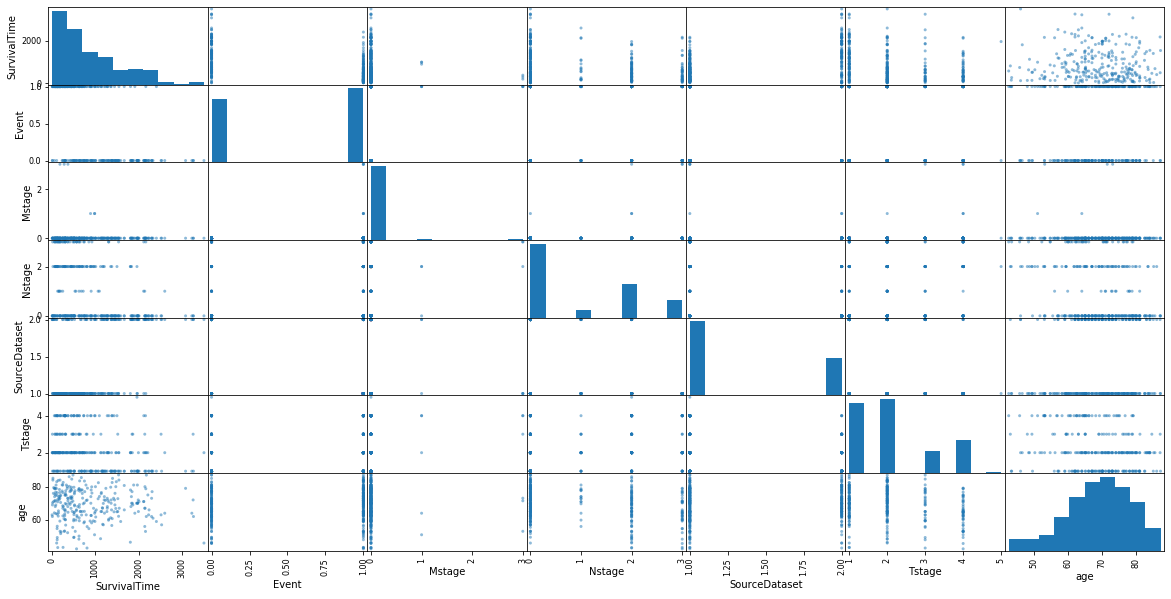

In [19]:
from pandas.plotting import scatter_matrix
attributes = ['SurvivalTime', 'Event', 'Mstage', 'Nstage','SourceDataset', 'Tstage', 'age']
scatter_matrix(data[attributes], figsize=(20,10));

> We don't visualize many impressive correlations, but as we want to predict `SurvivalTime`, `N Stage` seems to have a high impact. Additionnaly, `N Stage`and `T stage` seem to have pretty much the same distributions (Then why do we take `N Stage` in the predictions insted of `T Stage` ?).

Then, let's have a look at the proportion of patients that went off the study :

In [20]:
present_patients = np.array(data['Event'])
values = np.unique(present_patients,return_counts=True)[1]
proportions = 100*values/np.sum(values)
print('{} patients escaped the study   : proportion of {}%'.format(values[0],proportions[0]))
print('{} patients stayed in the study : proportion of {}%'.format(values[1],proportions[1]))

138 patients escaped the study   : proportion of 46.0%
162 patients stayed in the study : proportion of 54.0%


> Interesting for later considerations to notice that this is pretty balanced.

Let's plot Kaplan Meier survival curves :

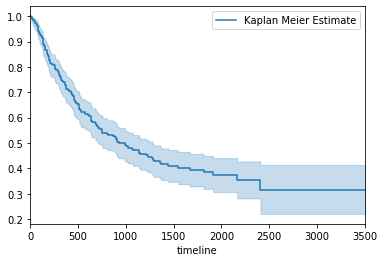

In [21]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter() 
kmf.fit(data['SurvivalTime'], data['Event'], label='Kaplan Meier Estimate')
kmf.plot();

> This is somehow a standard survival curve...

We also want to have an idea of the importance of the histology in the survival predictions :

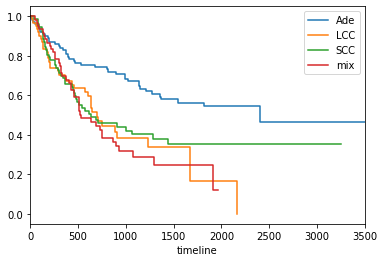

In [22]:
kmf = KaplanMeierFitter()
histo_data = data[data['Histology']=='Ade']
kmf.fit(histo_data['SurvivalTime'], histo_data['Event'], label='Ade')
a = kmf.plot(ci_show=False)
for histo_class in ['LCC','SCC','mix']:
    histo_data = data[data['Histology']==histo_class]
    kmf.fit(histo_data['SurvivalTime'], histo_data['Event'], label=histo_class)
    kmf.plot(ax=a,ci_show=False)

> Thus, it seems that depending on the `Histology`, a patient doesn't have the same survival properties. This might actually be of great interest when we will try to train our own model. Indeed, training it to predict the `Histology` might not infer in a too useless representation of the images for the survival prediction made by a cox model.

> Moreover, according to these curves we might be able to create a correct encoding for these text values. A common issue in text encoding is that 2 values encoded with the numbers 1 and 2 will be understood by the model as being closer to each other than 2 values encoded 1 and 4. Thus we could use OneHotEncoding, or according to the curves presented above, we can say that $$[Ade, LCC, SCC, mix]\ \ ->  [0, 2, 1, 3]$$ could be a good encoding since the curve are ranked in this order.

Let's encode our data :

In [23]:
# Let's manually encode it :
histo_array = np.array(data['Histology']).copy()
for idx in range(len(histo_array)):
    if histo_array[idx]=='Ade':
        histo_array[idx] = 0
    elif histo_array[idx]=='LCC':
        histo_array[idx] = 2
    elif histo_array[idx]=='SCC':
        histo_array[idx] = 1
    elif histo_array[idx]=='mix':
        histo_array[idx] = 3
        
data['Histology'] = pd.DataFrame(histo_array, columns=['Histology'], index=data.index).astype(int)

---
---
---

# II - Use a cox model to fit the data and get predictions

In [24]:
from lifelines import CoxPHFitter
import sksurv
from sksurv.linear_model import CoxPHSurvivalAnalysis

## II - A ) Use the cox model from scikit-survival library

### II - A - 1) Without using the images -> try to get the results presented on the web page of the challenge.

Let's know train a simple model only using the 53 features and clinical data :

In [25]:
clinical_data.head() # SourceDataset, Nstage

,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,Adenocarcinoma,0,0,2,2,66.0000
371,large cell,0,2,1,4,64.5722
246,squamous cell carcinoma,0,3,1,2,66.0452
240,nos,0,2,1,3,59.3566
284,squamous cell carcinoma,0,3,1,4,71.0554


From this one, we will select the following columns based on the indication to reproduce the results presented at https://challengedata.ens.fr/participants/challenges/33/ :
- SourceDataset
- Nstage

In [26]:
radiomics.head()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


From this one, we will select the following columns based on the indication to reproduce the results presented at https://challengedata.ens.fr/participants/challenges/33/ :
- original_shape_Sphericity
- original_shape_SurfaceVolumeRatio
- original_shape_Maximum3DDiameter
- original_glcm_JointEntropy
- original_glcm_Idm : inverse different moment
- original_glcm_Id : inverse difference

First, let's create both train and validation datasets. Quick remark : cross-validation is mainly used in order to select the best hyperparameters, but in for now we use thr cox model from lifelines which can't be tuned... Thus creating cross validation splits isn't relevant and working with train/val is enough.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=56)
splitting = split.split(data, data['Event'])#, data['SourceDataset'].values) 
# On which column do you want to keep the same distribution in both training and validation
### This way, we can try to prevent the model to be biased by the hospital origin,
### and more precisely the acquisition method.

for train, val in splitting:
    data_train = data.iloc[train]
    data_val = data.iloc[val]

**Start using lifelines function :**

In [131]:
def normalize_data(data_train, data_val):
    """
    Normalize each column applying the following pipeline : 
     - get the transformation coefficient on the training_set.
     - apply this very transformation to both data_train and data_val.
     - return the normalized datasets.
    """
    for col_name in data_train.drop(['SurvivalTime', 'Event'], axis=1).columns:
        mu, sigma = np.mean(data_train[col_name]), np.std(data_train[col_name])
        data_train[col_name] = (data_train[col_name]-mu)/sigma

        # Then apply this very transformation to the validation data :
        data_val[col_name] = (data_val[col_name] - mu)/sigma
    
    return data_train, data_val

def predict_lifelines_cox(data_train, data_val, features_names, normalize=False, show_summary=True):
    """
    Use lifelines' cox model to predict survival of patients based on specific features.
    
    Input:
        data_train: pd.DataFrame
            The training dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        data_val: pd.DataFrame
            The validation dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        feature_names: list
            A list of feature names to consider in the cox model.
        normalize: boolean
            Whether to normalize data or not.
        show_summary: boolean
            Whether to show the summary or not. This summary contains informations on which feature is important
            for the model, as well as the training results (CI score).
            
    Output:
        a tuple containing the cox model, data_train and data_val
    """
    data_train = data_train[features_names]
    data_val = data_val[features_names]
    
    if normalize:
        data_train, data_val = normalize_data(data_train, data_val)
        
    ### Training Phase and predictions on the validation dataset
    # Let's try to use a simple cox model
    cph = CoxPHFitter()
    cph.fit(data_train, 'SurvivalTime', event_col='Event')
    if show_summary:
        cph.print_summary() # Prints training results and how important is each feature
    #cph.plot() # Plots the importance of each feature
    #cph.predict_survival_function(data[['SurvivalTime', Event', 'Mstage',
    #                                        'Nstage', 'Tstage']].iloc[5:10,2:]).plot()
    
    pred = cph.predict_expectation(data_val.drop(['SurvivalTime', 'Event'], axis=1))
    pred.columns = ['SurvivalTime']
    pred.index.name = 'PatientID'
    pred = pd.concat([pred, data_val['Event']], axis=1)
    
    result = cindex(data_val[['SurvivalTime', 'Event']], pred)
    print('Performance on the validation set (CI) : {:.3f}'.format(result))

    return (cph, data_train, data_val)

Have an insight of the bias in data origin of our model :

In [30]:
prop_HP1 = len(data['SourceDataset'][data['SourceDataset']==1])/len(data)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))
prop_HP1 = len(data_train['SourceDataset'][data_train['SourceDataset']==1])/len(data_train)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))
prop_HP1 = len(data_val['SourceDataset'][data_val['SourceDataset']==1])/len(data_val)
print('{:.3f} %% of the data come from Hospital 1.'.format(prop_HP1))

0.663 %% of the data come from Hospital 1.
0.671 %% of the data come from Hospital 1.
0.633 %% of the data come from Hospital 1.


*NB, normalizing the data doesn't seem to have a huge impact here. We will consider this when implementing our own verison of a cox model, which will possibly use an SVM (requires data to be normalized).*

In [142]:
features_names = ['SurvivalTime', 'Event', 'Histology', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 
                  'original_shape_Maximum3DDiameter',
                  'original_glcm_JointEntropy',
                  'original_shape_SurfaceVolumeRatio', 
                  'original_glcm_Idm',
                  'original_glcm_Id']

(cph, _, _) = predict_lifelines_cox(data_train, data_val, features_names)

n=240, number of events=130

                                      coef         exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95   
Histology                           0.0880            1.0920    0.1016  0.8667 0.3861     -0.1110      0.2871   
SourceDataset                      -0.5870            0.5560    0.3892 -1.5081 0.1315     -1.3498      0.1759   
Nstage                              0.1856            1.2039    0.0795  2.3358 0.0195      0.0299      0.3413  *
original_shape_Sphericity           2.8294           16.9352    1.5611  1.8124 0.0699     -0.2303      5.8891  .
original_shape_Maximum3DDiameter    0.0109            1.0110    0.0046  2.3603 0.0183      0.0018      0.0199  *
original_glcm_JointEntropy          0.6011            1.8242    0.2968  2.0252 0.0429      0.0194      1.1829  *
original_shape_SurfaceVolumeRatio   1.5646            4.7810    1.2317  1.2703 0.2040     -0.8495      3.9788   
original_glcm_Idm                  26.5122 326673160366.2231   21.4

Given the concordance on the training set (0.705) and the one on the validation set (0.668), we probably overfit a bit... Let's consider fewer features based on their respective importance :

In [143]:
features_names = ['SurvivalTime', 'Event', 'Nstage', 
                  'original_shape_Maximum3DDiameter','original_glcm_JointEntropy',
                  'original_shape_Sphericity']

(cph, _, _) = predict_lifelines_cox(data_train, data_val, features_names)

n=240, number of events=130

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                            0.2647     1.3030    0.0776  3.4084 0.0007      0.1125      0.4168  ***
original_shape_Maximum3DDiameter  0.0093     1.0093    0.0041  2.2713 0.0231      0.0013      0.0173    *
original_glcm_JointEntropy       -0.1180     0.8887    0.0624 -1.8895 0.0588     -0.2404      0.0044    .
original_shape_Sphericity         2.3978    10.9991    1.2579  1.9062 0.0566     -0.0676      4.8633    .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.687
Likelihood ratio test = 42.732 on 4 df, p=0.00000
Performance on the validation set (CI) : 0.641


> Unfortunately, we may not overfit this time, but we definitely lost information...

**Try out the scikit-survival function :**

In [ ]:
def predict_sksurv_cox(data_train, data_val, features_names, alpha=1, normalize=False, show_summary=True):
    """
    Use lifelines' cox model to predict survival of patients based on specific features.
    
    Input:
        data_train: pd.DataFrame
            The training dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        data_val: pd.DataFrame
            The validation dataset. Must contain 'SurvivalTime', 'Event' and features_names in its columns.
        feature_names: list
            A list of feature names to consider in the cox model.
        normalize: boolean
            Whether to normalize data or not.
        show_summary: boolean
            Whether to show the summary or not. This summary contains informations on which feature is important
            for the model, as well as the training results (CI score).
            
    Output:
        a tuple containing the cox model, data_train and data_val
    """
    data_train = data_train[features_names]
    data_val = data_val[features_names]
    
    if normalize:
        data_train, data_val = normalize_data(data_train, data_val)
        
    ### Training Phase and predictions on the validation dataset
    # Let's try to use a simple cox model
    cph = CoxPHSurvivalAnalysis(alpha=alpha) #CoxPHFitter()
    
    events = np.array(data_train['Event'])
    SurvivalTime = np.array(data_train['SurvivalTime'])
    y_train = []
    for idx in range(len(data_train)):
        y_train.append((events[idx], SurvivalTime[idx]))
    y_train = np.array(y_train, dtype=[('Event', 'bool'), ('SurvivalTime', 'i4')])
    cph.fit(data_train.drop(['SurvivalTime','Event'],axis=1), y_train)
    
    train_result = cph.score(data_train.drop(['SurvivalTime','Event'],axis=1), y_train)
    
    events = np.array(data_val['Event'])
    SurvivalTime = np.array(data_val['SurvivalTime'])
    y_val = []
    for idx in range(len(data_val)):
        y_val.append((events[idx], SurvivalTime[idx]))
    y_val = np.array(y_val, dtype=[('Event', 'bool'), ('SurvivalTime', 'i4')])

    val_result = cph.score(data_val.drop(['SurvivalTime','Event'],axis=1), y_val)
    print('Performance on the training set (CI) : {:.3f}'.format(train_result))
    print('Performance on the validation set (CI) : {:.3f}'.format(val_result))

    return (cph, data_train, data_val)

In [114]:
features_names = ['SurvivalTime', 'Event', 'Histology', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 
                  'original_shape_Maximum3DDiameter',
                  'original_glcm_JointEntropy',
                  'original_shape_SurfaceVolumeRatio', 
                  'original_glcm_Idm',
                  'original_glcm_Id']

(cph, _, _) = predict_sksurv_cox(data_train, data_val, features_names, alpha=10000, normalize=True)

Performance on the training set (CI) : 0.680
Performance on the validation set (CI) : 0.669


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [120]:
features_names = ['SurvivalTime', 'Event', 'Nstage', 
                  'original_shape_Maximum3DDiameter','original_glcm_JointEntropy',
                  'original_shape_Sphericity']

(cph, _, _) = predict_sksurv_cox(data_train, data_val, features_names, alpha=500, normalize=True)

Performance on the training set (CI) : 0.679
Performance on the validation set (CI) : 0.663


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


---

### II - A - 2 ) Feature extraction from a slice (2D) of the CT scans (resnet50, pretrained='imagenet')

First approach : take the middle slice of the tumor and process this 2D image using a model pretrained on imagenet (able to recognize shapes and many images features).

In [121]:
def get_slice(scan, mask, slice_dim=None):
    """
    Using the mask volume of the scan, get the index of the slice containing most of the tumor.
    Then return the corresponding slice of the scan.
    
    slice_dim parameter allows to state a dimension along which to take the biggest slice. 
    If None, then thif function returns the biggest out of the 3 dimensions.
    """
    indexes = np.where(mask==1) # Get the indexes along each dimension of the mask
    nb_white_pixels = 0
    if slice_dim==None:
        for dim in range(len(mask.shape)):
            values = np.unique(indexes[dim], return_counts=True) 
            # This gives us the number of white pixels for each index in this dimension
            max_value = np.max(values[1]) # We get the maximal number of white pixel for the slices in this dimension
            if max_value > nb_white_pixels:
                nb_white_pixels = max_value
                preferred_slice = (dim, values[0][list(values[1]).index(max_value)])

    else:
        values = np.unique(indexes[slice_dim], return_counts=True) 
        # This gives us the number of white pixels for each index in this dimension
        max_value = np.max(values[1]) # We get the maximal number of white pixel for the slices in this dimension
        preferred_slice = (slice_dim, values[0][list(values[1]).index(max_value)])
                
                
    loc = [(0,92) for _ in range(preferred_slice[0])]
    loc += [(preferred_slice[1], preferred_slice[1]+1)]
    loc += [(0,92) for _ in range(2-preferred_slice[0])]
    slice_of_interest = scan[loc[0][0]:loc[0][1], loc[1][0]:loc[1][1], loc[2][0]:loc[2][1]]
    slice_of_interest = slice_of_interest.reshape(92,92)
    
    return slice_of_interest

For some patients, let's plot this biggest slice of the tumor (slice of interest) :

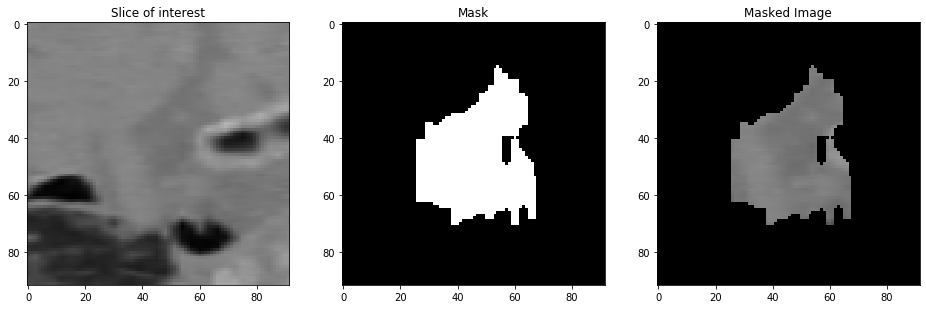

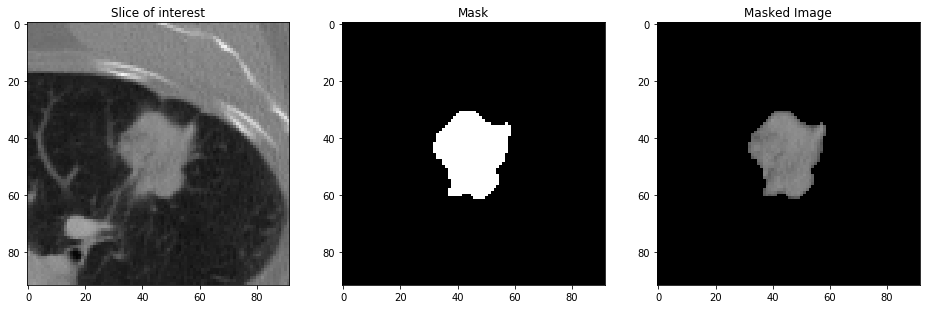

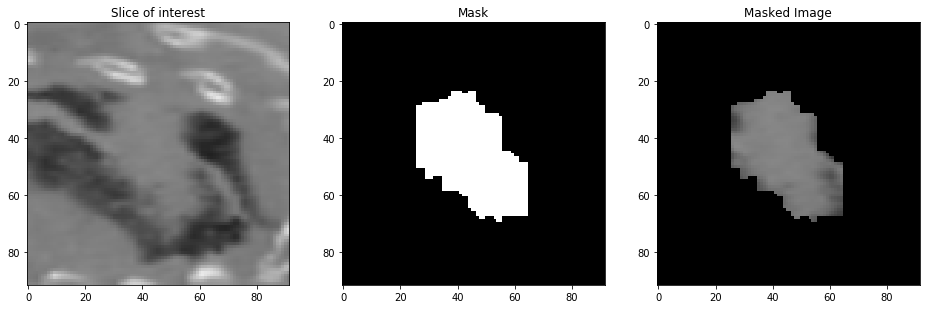

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


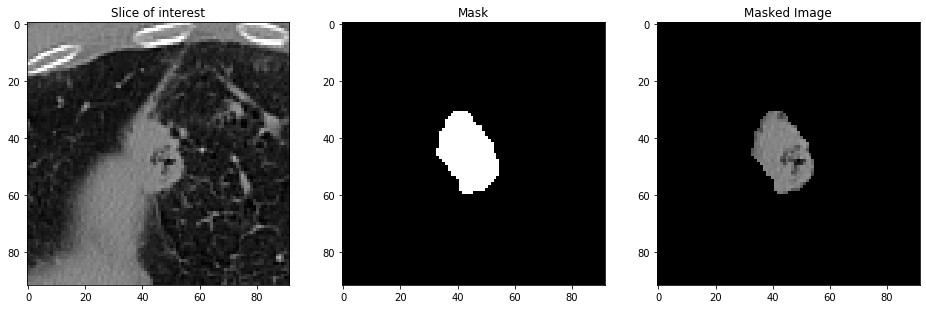

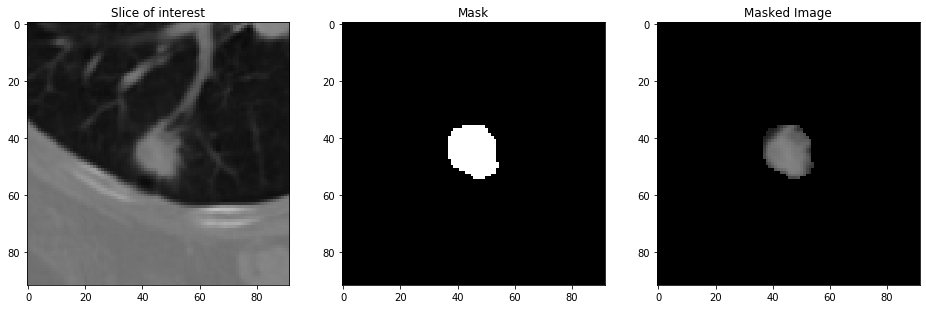

In [122]:
for patient_id in data_train.index[:5]:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    slice_of_interest = np.zeros((92,92,3))
    soi = get_slice(to_pixel_values(scan), mask)
    for dim in range(3):
        slice_of_interest[:,:,dim] = soi
    slice_of_interest = slice_of_interest.astype(int)
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(131)
    plt.imshow(slice_of_interest)
    plt.title('Slice of interest')
    
    mask_of_interest = np.zeros((92,92,3))
    moi = get_slice(mask, mask)
    for dim in range(3):
        mask_of_interest[:,:,dim] = moi
    mask_of_interest = mask_of_interest.astype(int)
    
    plt.subplot(132)
    plt.imshow(mask_of_interest*255)
    plt.title('Mask')
    
    plt.subplot(133)
    plt.imshow(mask_of_interest*slice_of_interest)
    plt.title('Masked Image')
    
    plt.show()

Import the model using torch :

In [123]:
import torchvision.models as models
import torch.nn as nn
import torch
model = nn.Sequential(*list(models.resnet50('imagenet').children())[:-2])
# -2 instead of -1 will take off the last AvgPool2d if I want to play a bit.
model = model.double()

Get the extracted features for each patient and build a dataframe :

In [124]:
def feature_extractor(over_masked_images=False, slice_dim=None):
    features_img = np.ndarray((len(training_labels),2048))

    for idx, patient_id in tqdm.tqdm(enumerate(training_labels.index)):
        # Load the image
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
        scan = archive['scan'] # a np.array
        mask = archive['mask'] # a np.array

        try: # for some patients we don't have the mask though
            # Get the slice of interest
            img = get_slice(scan, mask, slice_dim)
            img = to_pixel_values(img)
            if over_masked_images:
                masked_slice = get_slice(mask, mask)
                img *= masked_slice.astype(int)

        except: # For images for which we don't have any masks, we need to rethink our approach
            #print('An issue has occured for patient {}'.format(patient_id))
            ### Output : Patients 327, 256, 3, 391, 263 have issues.
            img = np.zeros((92,92))
            
        # Extract features from it using Resnet50
        img_bgr = np.zeros((1, 3, 92, 92))
        for dim in range(3):
            img_bgr[0,dim,:,:] = img
        with torch.no_grad():
            img_bgr = torch.from_numpy(img_bgr/255.)
            img_bgr = img_bgr.type('torch.DoubleTensor')
            #torch.utils.data.DataLoader(train_dataset, batch_size=1)
            slice_features = model(img_bgr).numpy()
        slice_features = slice_features.mean(2).mean(2)
        slice_features = slice_features.flatten()
        features_img[idx] = slice_features

    columns_names = ['Img_Feature_{}'.format(i) for i in range(1,2049)]

    img_features_df = pd.DataFrame(features_img, columns=columns_names, index=training_labels.index)
    
    return img_features_df

img_features_df = feature_extractor()

300it [01:10,  4.26it/s]


In [125]:
img_features_df.head()

,Img_Feature_1,Img_Feature_2,Img_Feature_3,Img_Feature_4,Img_Feature_5,Img_Feature_6,Img_Feature_7,Img_Feature_8,Img_Feature_9,Img_Feature_10,...,Img_Feature_2039,Img_Feature_2040,Img_Feature_2041,Img_Feature_2042,Img_Feature_2043,Img_Feature_2044,Img_Feature_2045,Img_Feature_2046,Img_Feature_2047,Img_Feature_2048
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.343396,0.480997,0.574364,0.384664,0.457811,0.497613,0.525142,0.451244,0.429529,0.593764,...,0.383884,0.488671,0.378356,0.395469,0.471513,0.159779,0.393104,0.315369,0.429333,0.340765
371,0.427483,0.625572,0.459051,0.438079,0.479484,0.508365,0.548611,0.470015,0.357419,0.291761,...,0.459865,0.478431,0.435634,0.302019,0.458117,0.108944,0.403599,0.327929,0.448080,0.288398
246,0.328621,0.547753,0.426236,0.441431,0.405119,0.474290,0.584534,0.533232,0.317885,0.276911,...,0.415539,0.402117,0.430649,0.348916,0.460762,0.157758,0.473265,0.341746,0.422360,0.312749
240,0.362312,0.524311,0.487430,0.363619,0.604511,0.494696,0.577124,0.501981,0.462962,0.530389,...,0.372950,0.512411,0.498755,0.363923,0.384840,0.151933,0.442702,0.324166,0.406181,0.368282
284,0.373992,0.628258,0.406065,0.359042,0.539771,0.452282,0.524535,0.515526,0.439546,0.510069,...,0.415139,0.390698,0.394378,0.327192,0.444154,0.166435,0.437151,0.330760,0.375219,0.353651


Issues have occured for these patients :
- 327
- 256
- 3
- 391
- 263

Let's verify their masks and remove them from the database for now :

In [127]:
reduced_img_features_df = img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    if np.all(mask==0):
        print('Patient {} has a full dark mask.'.format(patient_id))
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

Patient 327 has a full dark mask.
Patient 256 has a full dark mask.
Patient 3 has a full dark mask.
Patient 391 has a full dark mask.
Patient 263 has a full dark mask.


However, since 2048 features are far too many for a model with less than 300 patients, let's apply a PCA to reduce the space dimension :

In [128]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=50) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)
print("Shape of transformed data : ", ld_data.shape)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

Shape of transformed data :  (295, 50)


In [129]:
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [132]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val) = predict_lifelines_cox(reduced_data_train, 
                                                                reduced_data_val, features_names)

n=236, number of events=129

                                     coef     exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                     -0.5205        0.5942    0.4328 -1.2027 0.2291     -1.3687      0.3277     
Nstage                             0.1528        1.1651    0.1000  1.5280 0.1265     -0.0432      0.3488     
original_shape_Sphericity          4.4706       87.4058    1.8349  2.4365 0.0148      0.8743      8.0668    *
original_shape_SurfaceVolumeRatio  4.5496       94.5907    1.7209  2.6437 0.0082      1.1767      7.9224   **
original_shape_Maximum3DDiameter   0.0223        1.0226    0.0063  3.5720 0.0004      0.0101      0.0346  ***
original_glcm_JointEntropy         0.8144        2.2578    0.3860  2.1098 0.0349      0.0578      1.5709    *
original_glcm_Idm                 17.9225 60766175.5185   26.1268  0.6860 0.4927    -33.2851     69.1302     
original_glcm_Id                  -8.9462        0.0001   30.4585 -0.2937 0.7690    -68.643

The concordance presented by the model is 0.762 whereas the performance on the validation set is 0.667. Our model clearly overfits so we will reduce the number of parameters by selecting only the best params. Let's iterate this method until all parameters are important for the model :

In [133]:
def lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05):
    p_value_thresh = 0.05
    # p_value_thresh = 0.05 select all features having at least a '*'
    # p_value_thresh = 0.1 selects all features having at least a '.'
    p_values = np.array(cph._compute_p_values())
    while not np.all(p_values<p_value_thresh):
        good_features = []
        for idx, feature in enumerate(features_names[2:]):
            if p_values[idx] < p_value_thresh: 
                good_features.append(feature)

        features_names = ['SurvivalTime', 'Event'] + good_features
        (cph, _, _) = predict_lifelines_cox(reduced_data_train, reduced_data_val, features_names, show_summary=False)
        p_values = np.array(cph._compute_p_values())

    cph.print_summary()
    
lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05)

Performance on the validation set (CI) : 0.700
Performance on the validation set (CI) : 0.686
n=236, number of events=129

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
original_shape_Sphericity         3.7807    43.8483    1.1744  3.2194 0.0013      1.4790      6.0825   **
original_shape_Maximum3DDiameter  0.0165     1.0167    0.0033  4.9648 0.0000      0.0100      0.0231  ***
Img_Feature_4                    -0.8400     0.4317    0.4045 -2.0767 0.0378     -1.6328     -0.0472    *
Img_Feature_10                   -1.0958     0.3343    0.4518 -2.4254 0.0153     -1.9813     -0.2103    *
Img_Feature_20                   -0.9030     0.4054    0.4518 -1.9987 0.0456     -1.7885     -0.0175    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.659
Likelihood ratio test = 40.106 on 5 df, p=0.00000


Using only these, we don't overfit that much !

> Nevertheless, this approach doesn't yield great results...

**Scikit-survival :**

In [144]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, alpha=500, normalize=False)

Performance on the training set (CI) : 0.673
Performance on the validation set (CI) : 0.699


---

### II - A - 3 ) Feature extraction from a slice (2D) of the masked CT scans (resnet50, pretrained='imagenet')

Still trying to level up difficulty or going a bit further in the progression and with our approach, we will select this time the masked images to make use of the masks that we have with our dataset.

Exactly as before :

In [145]:
### Extract Features
img_features_df = feature_extractor(over_masked_images=True)

300it [01:15,  3.95it/s]


In [147]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=100) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

columns_names = ['Img_Feature_{}'.format(i) for i in range(1,ld_data.shape[1]+1)]

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index, columns=columns_names)

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

Now, let's fit the model :

**Lifelines :**

In [148]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val) = predict_lifelines_cox(reduced_data_train, 
                                                                reduced_data_val, features_names)

n=236, number of events=129

                                      coef                      exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                      -0.7135                         0.4899    0.5931 -1.2030 0.2290     -1.8759      0.4489     
Nstage                              0.3559                         1.4274    0.1549  2.2972 0.0216      0.0522      0.6595    *
original_shape_Sphericity         -12.3275                         0.0000    4.0247 -3.0629 0.0022    -20.2158     -4.4391   **
original_shape_SurfaceVolumeRatio  -6.5609                         0.0014    4.0117 -1.6354 0.1020    -14.4237      1.3019     
original_shape_Maximum3DDiameter   -0.0131                         0.9870    0.0120 -1.0934 0.2742     -0.0365      0.0104     
original_glcm_JointEntropy          1.0758                         2.9322    0.5583  1.9269 0.0540     -0.0185      2.1700    .
original_glcm_Idm                 -35.2001                         0.0000  

And finally, iterate to select only relevant features :

In [149]:
lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05)

Performance on the validation set (CI) : 0.566
Performance on the validation set (CI) : 0.616
Performance on the validation set (CI) : 0.616
n=236, number of events=129

                  coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage          0.3217     1.3795    0.0784  4.1033 0.0000      0.1680      0.4754  ***
Img_Feature_1  -0.5046     0.6038    0.2155 -2.3413 0.0192     -0.9270     -0.0822    *
Img_Feature_30 -1.1681     0.3110    0.5127 -2.2784 0.0227     -2.1729     -0.1633    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.657
Likelihood ratio test = 35.314 on 3 df, p=0.00000


> This approach yields even worse results ! Anyway, let's head to another approach which is trying to consider the whole CT scan volume and not only the biggest slice.

**Scikit-survival :**

In [150]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, alpha=500, normalize=False)

Performance on the training set (CI) : 0.674
Performance on the validation set (CI) : 0.698


---

### II - A - 3 ) Feature extraction from 3 slices (2D) of the CT scans (resnet50, pretrained='imagenet')

Let's try to extract features from each biggest slice along each dimension of the CT scan. Thus we get 3 images and get $3*2048$ features (in order to use the 3D property of our data this time) :

-1022 1132
False True


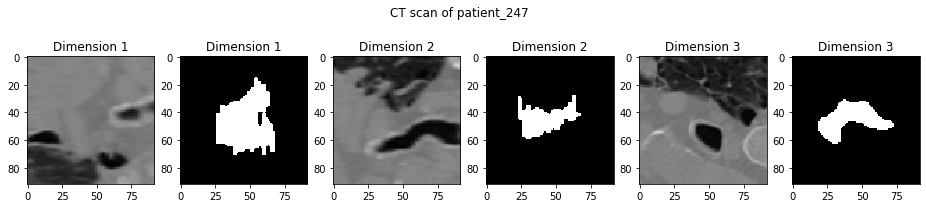

-1018 1230
False True


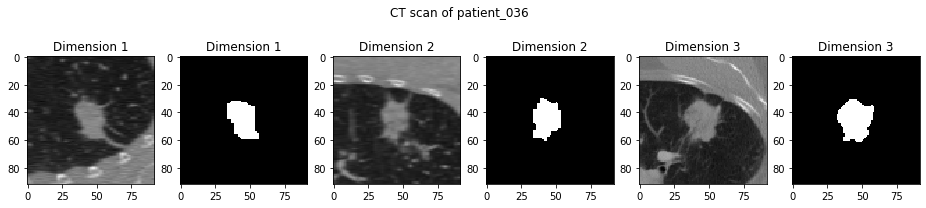

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1024 1164
False True


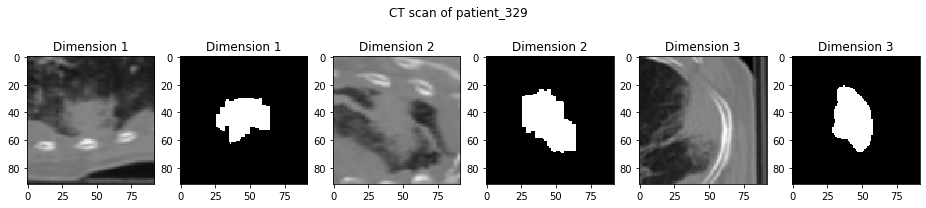

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1024 2105
False True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


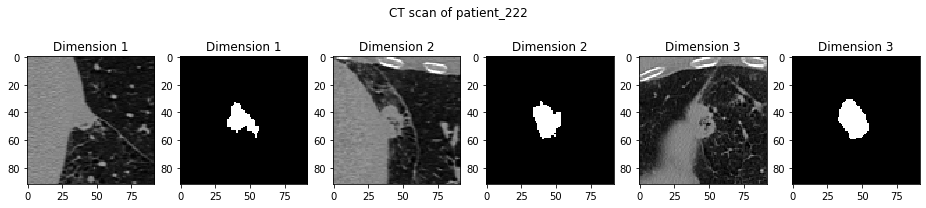

-1005 764
False True


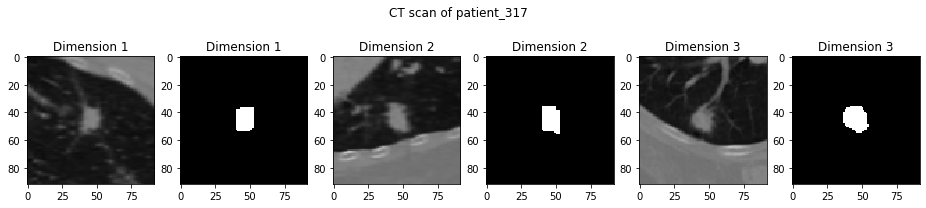

In [155]:
for patient_id in data_train.index[:5]:
    patient_id_str = '00'+str(patient_id)
    patient_id_str = patient_id_str[-3:]
    archive = np.load(os.path.join(train_root,'images/patient_{}.npz'.format(patient_id_str)))
    scan = archive['scan'] # a np.array
    mask = archive['mask'] # a np.array
    
    print(np.min(scan), np.max(scan))
    print(np.min(mask), np.max(mask))
    
    plt.figure(figsize=(16,8))
    plt.suptitle('CT scan of patient_{}'.format(patient_id_str), y=0.7)
    
    for slice_dim in range(3):
        slice_of_interest = np.zeros((92,92,3))
        soi = get_slice(to_pixel_values(scan), mask, slice_dim)
        for dim in range(3):
            slice_of_interest[:,:,dim] = soi
        slice_of_interest = slice_of_interest.astype(int)
    
        plt.subplot(1,6,2*slice_dim+1)
        plt.imshow(slice_of_interest)
        plt.title('Dimension {}'.format(slice_dim+1))
        
        mask_of_interest = np.zeros((92,92,3))
        moi = get_slice(mask, mask, slice_dim)
        for dim in range(3):
            mask_of_interest[:,:,dim] = moi
        mask_of_interest = mask_of_interest.astype(int)*255
    
        plt.subplot(1,6,2*slice_dim+2)
        plt.imshow(mask_of_interest)
        plt.title('Dimension {}'.format(slice_dim+1))

    plt.show()

In [152]:
img_features_dim = []
for slice_dim in range(3):
    img_features_dim.append(feature_extractor(over_masked_images=False, slice_dim=slice_dim))

300it [01:05,  4.60it/s]
300it [01:11,  4.21it/s]
300it [01:07,  4.48it/s]


In [450]:
new_columns_names = ['Img{}_Feature_{}'.format(slice_dim, feat_idx) for slice_dim in range(3) for feat_idx in range(1,2049)]
new_index_names = img_features_dim[0].index
triple_img_features_df = pd.concat(img_features_dim, axis=1)
triple_img_features_df.columns, triple_img_features_df.index = new_columns_names, new_index_names

In [ ]:
#-----------------------------------------------------------------------------------------------------
### Remove irrelevant patients
reduced_img_features_df = triple_img_features_df.copy()
reduced_data_train = data_train.copy()
reduced_data_val = data_val.copy()

no_masks_patients = [327,256,3,391,263]
for patient_id in no_masks_patients:
    reduced_img_features_df = reduced_img_features_df.drop(patient_id,axis='index')
    try:
        reduced_data_train = reduced_data_train.drop(patient_id,axis='index')
    except:
        reduced_data_val = reduced_data_val.drop(patient_id,axis='index')

#-----------------------------------------------------------------------------------------------------
### Apply PCA
from sklearn.decomposition import PCA
transformer = PCA(n_components=50) # keep only 100 features
# using PCA(0.99, whiten=True), we can ask it to preserve 99% of the variance in the projected data
ld_data = transformer.fit_transform(reduced_img_features_df)

reduced_img_features_df = pd.DataFrame(ld_data, index=reduced_img_features_df.index,
                                   columns=columns_names[:ld_data.shape[1]])

#-----------------------------------------------------------------------------------------------------
### Create relevant splits
# Apply the splitting process to the dataframe containing the features
data_features_train = reduced_img_features_df.loc[reduced_data_train.index]
data_features_val = reduced_img_features_df.loc[reduced_data_val.index]

# Rebuild the split using all available columns
reduced_data_train = data.loc[reduced_data_train.index]
reduced_data_val = data.loc[reduced_data_val.index]

# Concatenate the related dataframes to build the splits
reduced_data_train = pd.concat([reduced_data_train, data_features_train], axis=1)
reduced_data_val = pd.concat([reduced_data_val, data_features_val], axis=1)

**Lifelines :**

In [ ]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, reduced_data_train, reduced_data_val) = predict_lifelines_cox(reduced_data_train, reduced_data_val,
                                                                    features_names)

And finally, iterate to select only relevant features :

In [668]:
lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05)

Performance on the validation set (CI) : 0.677
Performance on the validation set (CI) : 0.655
n=236, number of events=129

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
original_shape_Sphericity         2.8188    16.7560    1.1416  2.4691 0.0135      0.5812      5.0563    *
original_shape_Maximum3DDiameter  0.0169     1.0170    0.0032  5.2195 0.0000      0.0105      0.0232  ***
Img_Feature_13                   -0.7704     0.4628    0.2877 -2.6780 0.0074     -1.3342     -0.2066   **
Img_Feature_38                    0.7660     2.1511    0.3259  2.3504 0.0188      0.1272      1.4047    *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.657
Likelihood ratio test = 40.468 on 4 df, p=0.00000


**Scikit-survival :**

In [150]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, alpha=500, normalize=False)

Performance on the training set (CI) : 0.674
Performance on the validation set (CI) : 0.698


Unfortunately we get even worse results... The issue probably come from the PCA to reduce the number of parameters which is much to high in a resnet50...

Then, we should try with a resnet18 which extracts 512 features instead of 2048 and capturing convenient features !

---

### II - A - 4 ) Train our own small 3D CNN on a regression task and eventually use it to extract features

Now, we would like to make full use of the 3D property of our data and not only what is called 2,5D. Why do we create our own model ? Well, first of all to the best of my knowledge there isn't any pretrained 3D model available in the litterature, and moreover, a model pretrained on imagenet as before might not be very good to study medical images. For these reasons, we will build our own 3D model using dilated kernels (their efficiency in 3D has been proven in the litterature or at least they are widely used).

Usually Deep Learning is  used for classification. Thus we could train a network to predict the histology of our cohort and then use the network to extract features. But is this approach really a good one ? Indeed, a representation of the images learned by a network trying to predict which tumour it is might not be a good representation to predict survival (cf the survival curves plotted before)...

> A better approach could be instead to remove the final softmax or sigmoid and choose to have only one final neuron. This way our network would be able to perform regression. We then train this network to predict patients' survival : such a network is more likely to get better representations of the tumours for our task. If we do have such a network and that it is trained, then we would have two options : either use the predictions to get a CI score (but in this case the network don't get the subtle issue of patients leaving the study) or use it to extract relevant features for survival prediction that could be passed into a cox model as we did before.

In [151]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [631]:
class Regressor(nn.Module):
    
    def __init__(self):
        super(Regressor,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=18, kernel_size=5, dilation=2)
        #
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(in_channels=18, out_channels=32, kernel_size=3, dilation=2)
        self.fc1 = nn.Linear(32 * 19 * 19 * 19, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256,1)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 19 * 19 * 19)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Regressor()
print(model) # Print the layers containing trainable parameters only.

Net(
  (conv1): Conv3d(1, 18, kernel_size=(5, 5, 5), stride=(1, 1, 1), dilation=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(18, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2))
  (fc1): Linear(in_features=219488, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


What could be nice is to implement data augmentation for 3D volumes but does it work that easily ? Moreover, it is important that augmented images are still possible images we could come across (stay in the same distribution) ! In our case, we can see the ribs sometimes and the patient seem to be always in the same position with its organs located at certain places. Augmenting the data with rotations and symmetry might not make that much sense... If needed in the future (if I have time and that I have changed my mind), here is the code in 2D to do it :

```python

import cv2
import numpy as np


class Preprocessing(): 
    def __init__(self, config): 
        self.transforms = []
        if hasattr(config, 'resize'):
            self.transforms.append(Resize(config.resize.scale, keep_ratio=config.resize.keep_ratio))
        if hasattr(config, 'random_rotation'): 
            self.transforms.append(Random_rotation(config.random_rotation.angle))
        if hasattr(config, 'random_crop'): 
            self.transforms.append(Random_crop(config.random_crop.proportion))
        if hasattr(config, 'random_flip'): 
            self.transforms.append(Random_flip(config.random_flip.probability))
            
    def __call__(self,img): 
        for t in self.transforms: 
            img = t(img)
        return img
    
    
class Resize():
    
    def __init__(self, scale, keep_ratio=True):
            self.scale = scale
            self.keep_ratio = keep_ratio
            
    def __call__(self, img): 
        if self.keep_ratio:
            h, w, _ = img.shape
            ratio = max(self.scale[0] / h, self.scale[1] / w)
            img = cv2.resize(img, dsize=None, fx=ratio, fy=ratio)
            img = cv2.copyMakeBorder(img, max(0, self.scale[0] - img.shape[0]) // 2, 
                                         max(0, self.scale[0] - img.shape[0]) // 2 + 1,
                                         max(0, self.scale[1] - img.shape[1]) // 2,
                                         max(0, self.scale[1] - img.shape[1]) // 2 + 1,
                                         cv2.BORDER_CONSTANT, 0)
            h, w, _ = img.shape
            img = img[h // 2 - self.scale[0] // 2 : h // 2 + self.scale[0] // 2 ,
              w // 2 - self.scale[1] // 2 : w // 2 + self.scale[1] // 2 ,:]
        else: 
            raise NotImplementedError('keep ratio == False is  not implemented')
        return img
    
    
class Random_rotation():
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, img):
        rows,cols,_ = img.shape
        angle = (2 * np.random.random() - 1) * self.angle 
        M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
        img = cv2.warpAffine(img,M,(cols,rows))
        return img
        
class Random_crop():
    def __init__(self, proportion):
        self.proportion = proportion
    def __call__(self, img): 
        proportion = 1 - (1- self.proportion) * np.random.random()
        h, w, _ = img.shape 
        x_min, y_min = np.random.randint(0, max(1,h - proportion * h)) , np.random.randint(0, max(1,w - proportion * w)) 
        img = img[x_min : x_min + int(proportion * h),
                  y_min : y_min + int( proportion * w), :]
        return img
    
class Random_flip():
    def __init__(self, probability):
        self.probability = probability
    def __call__(self, img): 
        if np.random.random() < self.probability :
            img = cv2.flip(img, flipCode=1)
        return img
    
```

We need to create the dataset class properly in order to be called by torch's `DataLoader` function.

In [157]:
class SurvivalDataset(object):
    '''
    The SurvivalDataset instance inherit from the standard torch.utils.data.Dataset, it 
    corresponds to the survival dataset structure
    
    Parameters
    ----------
    image_dir : str
        path to the data main folder
        
    info_file : pandas DataFrame 
        file containing the images info
        
    split_name : str in ['train', 'val', 'test']
        which type of split it is
    
    augmentation : dict
        which augmentation to apply to data
    
    Attributes
    ----------
    image_dir : str 
        path to the data main folder which contains the
        images in training_data/images or test_data/images
    samples : pandas.Dataframe
        the Dataframe containing the information about the different images of the dataset
    '''
    def __init__(self, image_dir, info_file, split_name, augmentation=None):
        self.image_dir = image_dir
        # load all image files, sorting them to
        # ensure that they are aligned 
        
        self.samples = info_file
        
        self.samples.rename(columns={'SurvivalTime':'label'}, inplace=True)
            
        if split_name == 'train' and augmentation!=None:
            self.augmentation = Preprocessing(augmentation)
        else : 
            self.augmentation = None   
        
        
    def __getitem__(self, idx):
        # load images and masks
        infos = self.samples.iloc[idx]
        patient_id = infos.name
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join(self.image_dir, path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        infos = infos.to_dict()
        
        if self.augmentation is not None: 
            img = self.augmentation(img)
        img = img.copy().astype(np.float32, copy=True) / 255
        img = img.reshape(1,92,92,92)
        return img, infos
    
    def __len__(self):
        return self.samples.shape[0]

Now, we have to train this NN regressor :

In [599]:
import torch.optim as optim

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train, split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=24, num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val, split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=24, num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Regressor()
model.to(device)

loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model.train()
for epoch in range(3): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        # get the inputs
        inputs, labels = inputs.to(device), (labels['label']).to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.6e}\t Loss: {:.6e}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            inputs, labels = inputs.to(device), (labels['label']).to(device)
            output = model(inputs)
            labels = labels.type(torch.float32)/1000. # In order to prevent NaN issues
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {}'.format(epoch, val_loss))
        
torch.save(model.state_dict(), './my_reg_CNN_3D.pth')

my_model = model
            
print('Finished Training')

Train Epoch: 0 [0/240 (0%)]	avg Loss: 1.614862e+00	 Loss: 1.614862e+00
Train Epoch: 0 [24/240 (10%)]	avg Loss: 1.647940e+00	 Loss: 1.945638e+00
Train Epoch: 0 [48/240 (20%)]	avg Loss: 1.563093e+00	 Loss: 7.994737e-01
Train Epoch: 0 [72/240 (30%)]	avg Loss: 1.464561e+00	 Loss: 5.777713e-01
Train Epoch: 0 [96/240 (40%)]	avg Loss: 1.446841e+00	 Loss: 1.287360e+00
Train Epoch: 0 [120/240 (50%)]	avg Loss: 1.373188e+00	 Loss: 7.103094e-01
Train Epoch: 0 [144/240 (60%)]	avg Loss: 1.354104e+00	 Loss: 1.182345e+00
Train Epoch: 0 [168/240 (70%)]	avg Loss: 1.280946e+00	 Loss: 6.225324e-01
Train Epoch: 0 [192/240 (80%)]	avg Loss: 1.187098e+00	 Loss: 3.424574e-01
Train Epoch: 0 [216/240 (90%)]	avg Loss: 1.150147e+00	 Loss: 8.175908e-01
epoch : 0, val_loss : 0.7608572840690613
Train Epoch: 1 [0/240 (0%)]	avg Loss: 5.900698e-01	 Loss: 5.900698e-01
Train Epoch: 1 [24/240 (10%)]	avg Loss: 5.972984e-01	 Loss: 6.623559e-01
Train Epoch: 1 [48/240 (20%)]	avg Loss: 5.874622e-01	 Loss: 4.989362e-01
Train Epo

If needed, I can now reload the model using :

```python
my_model = Net()
my_model.load_state_dict(torch.load('./my_reg_CNN_3D.pth'))
```

Now let's test it on the validation set :

**1 - Computing directly the survival in days**

In [ ]:
# Evaluate the model on the validation set
predictions = []
my_model.eval()
with torch.no_grad():
    for patient_id in tqdm.tqdm(data_val.index):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True) / 255
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        img = img.to(device)
        output = my_model(img)*1000. # Because of our trick to prevent NaN issues in the training.
        predictions.append(output.numpy())
        
predictions = pd.DataFrame(np.array(predictions).flatten(), columns=['SurvivalTime'], index=data_val.index)
predictions

In [614]:
pred = pd.concat([predictions, data_val['Event']], axis=1)
    
data_val.rename(columns={'label':'SurvivalTime'}, inplace=True)
result = cindex(data_val[['SurvivalTime', 'Event']], pred)
print('Performance on the validation set (CI) : {:.3f}'.format(result))

Performance on the validation set (CI) : 0.268


> Hmm, unfortunately it really doesn't work that well...

**2 - Use the 3D_CNN to extract relevant features**

In [ ]:
# Evaluate the model on the validation set
model_list = list(my_model.children())[:-1]
p1_model_list = model_list[:3] + [model_list[1]]
p2_model_list = model_list[3:]
trunc_model_p1 = nn.Sequential(*p1_model_list)
trunc_model_p2 = nn.Sequential(*p2_model_list)
features_img = np.ndarray((len(data),256))
#trunc_model.eval()
with torch.no_grad():
    for idx, patient_id in tqdm.tqdm(enumerate(data.index)):
        patient_id_str = '00'+str(patient_id)
        patient_id_str = patient_id_str[-3:]
        path = 'patient_{}.npz'.format(patient_id_str)
        img_path = os.path.join('training_data/images', path)
        scan = np.load(img_path)['scan']
        img = to_pixel_values(scan)
        
        img = img.copy().astype(np.float32, copy=True) / 255
        img = img.reshape(1,1,92,92,92)
        img = torch.from_numpy(img)
        img = img.to(device)
        interm = trunc_model_p1(img)
        interm = interm.view(-1, 32 * 19 * 19 * 19)
        output = trunc_model_p2(interm)
        features_img[idx] = output.numpy()
        
features_3D = pd.DataFrame(features_img, columns=['Feature_3D_{}'.format(k) for k in range(1,257)], 
                           index=data.index)
features_3D

**Lifelines :**

In [675]:
cph, features_names, reduced_data_train, reduced_data_val = test_img_dataframe(features_3D,
                                                                               pca_size=30)

n=236, number of events=129

                                      coef    exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SourceDataset                      -0.6825       0.5053    0.4308 -1.5843 0.1131     -1.5269      0.1618     
Nstage                              0.3473       1.4152    0.0993  3.4968 0.0005      0.1526      0.5420  ***
original_shape_Sphericity           3.8789      48.3715    1.9067  2.0343 0.0419      0.1418      7.6161    *
original_shape_SurfaceVolumeRatio   3.1168      22.5737    1.5661  1.9902 0.0466      0.0473      6.1862    *
original_shape_Maximum3DDiameter    0.0149       1.0150    0.0058  2.5635 0.0104      0.0035      0.0263    *
original_glcm_JointEntropy          0.5250       1.6904    0.3400  1.5438 0.1226     -0.1415      1.1914     
original_glcm_Idm                  14.1694 1424665.3772   26.0344  0.5443 0.5863    -36.8571     65.1960     
original_glcm_Id                  -11.7568       0.0000   30.7865 -0.3819 0.7025    -72.097

In [676]:
lifelines_cox_param_selection(cph, features_names, reduced_data_train, reduced_data_val, p_value_thresh=0.05)

Performance on the validation set (CI) : 0.626
Performance on the validation set (CI) : 0.640
Performance on the validation set (CI) : 0.664
n=236, number of events=129

                                    coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
Nstage                            0.3146     1.3697    0.0751  4.1906 0.0000      0.1674      0.4617  ***
original_shape_Sphericity         3.9931    54.2232    1.2151  3.2863 0.0010      1.6116      6.3746   **
original_shape_Maximum3DDiameter  0.0170     1.0171    0.0035  4.8348 0.0000      0.0101      0.0238  ***
Img_Feature_18                   -7.4110     0.0006    3.3260 -2.2282 0.0259    -13.9297     -0.8922    *
Img_Feature_22                    8.3972  4434.5470    3.7338  2.2490 0.0245      1.0792     15.7152    *
Img_Feature_24                   10.9924 59420.7429    4.0739  2.6982 0.0070      3.0077     18.9771   **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.693

**Scikit-survival :**

In [150]:
features_names = ['SurvivalTime', 'Event', 'SourceDataset', 'Nstage', 
                  'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 
                  'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy',
                  'original_glcm_Idm','original_glcm_Id'] + list(reduced_img_features_df.columns)

(cph, _, _) = predict_sksurv_cox(reduced_data_train, reduced_data_val, features_names, alpha=500, normalize=False)

Performance on the training set (CI) : 0.674
Performance on the validation set (CI) : 0.698


---

### II - A - 4 ) Train our own small 3D CNN on a classification task and eventually use it to extract features

Given the metric score (CI), we don't need to predict the exact survival in days in order to get a good score ! Thus, we will use the `argsort` function of numpy to get labels for classification.

In [155]:
class Classifier(nn.Module):
    
    def __init__(self, batch_size):
        super(Classifier,self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=18, kernel_size=5, dilation=2)
        #
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(in_channels=18, out_channels=32, kernel_size=3, dilation=2)
        self.fc1 = nn.Linear(32 * 19 * 19 * 19, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256,batch_size)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 19 * 19 * 19)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Classifier(24)
print(model) # Print the layers containing trainable parameters only.

Classifier(
  (conv1): Conv3d(1, 18, kernel_size=(5, 5, 5), stride=(1, 1, 1), dilation=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(18, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), dilation=(2, 2, 2))
  (fc1): Linear(in_features=219488, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=24, bias=True)
)


In [166]:
import torch.optim as optim

batch_size = 24

train_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_train, split_name='train')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                                num_workers=0, drop_last=True)
validation_dataset = SurvivalDataset(image_dir='training_data/images', info_file=data_val, split_name='val')
val_data_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size,
                                              num_workers=0, drop_last=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Classifier(batch_size)
model.to(device)

loss_function = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(3): # loop over the dataset multiple times
    avg_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_data_loader,0): 
        labels = labels['label']
        orders = torch.argsort(labels)
        for idx, ordr in enumerate(orders):
            labels[ordr] = idx
            
        labels = labels.type(torch.int64)
        # get the inputs
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        print(outputs, labels)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            
        if avg_loss == 0 : 
            avg_loss = loss.item()
        avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tavg Loss: {:.6e}\t Loss: {:.6e}'.format(
                epoch, batch_idx * len(inputs), len(train_data_loader.dataset),
                100. * batch_idx / len(train_data_loader), avg_loss, loss.item()))
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        for batch_idx, (inputs, labels) in enumerate(val_data_loader):
            labels = labels['label']
            orders = torch.argsort(labels)
            for idx, ordr in enumerate(orders):
                labels[ordr] = [idx]
            
            labels = labels.type(torch.int64)
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            validation_loss += loss_function(output, labels).item()  # sum up batch loss

        val_loss = validation_loss/len(val_data_loader)
        print('epoch : {}, val_loss : {}'.format(epoch, val_loss))
        
torch.save(model.state_dict(), './my_Cla_CNN_3D.pth')

my_model = model
            
print('Finished Training')

tensor([[ 0.0450,  0.0277, -0.0068, -0.0349,  0.0168, -0.0442,  0.0348, -0.0099,
          0.0241,  0.0138, -0.0211, -0.0323,  0.0665,  0.0033, -0.0293, -0.0383,
         -0.0395, -0.0371,  0.0352,  0.0307, -0.0002,  0.0362, -0.0644, -0.0416],
        [ 0.0453,  0.0295, -0.0043, -0.0367,  0.0173, -0.0447,  0.0385, -0.0091,
          0.0226,  0.0149, -0.0230, -0.0316,  0.0671,  0.0019, -0.0299, -0.0341,
         -0.0390, -0.0389,  0.0366,  0.0305, -0.0001,  0.0394, -0.0638, -0.0442],
        [ 0.0451,  0.0250, -0.0034, -0.0314,  0.0187, -0.0445,  0.0347, -0.0091,
          0.0228,  0.0161, -0.0190, -0.0353,  0.0656,  0.0059, -0.0253, -0.0363,
         -0.0379, -0.0352,  0.0364,  0.0283, -0.0002,  0.0370, -0.0657, -0.0437],
        [ 0.0414,  0.0279, -0.0094, -0.0342,  0.0197, -0.0442,  0.0324, -0.0065,
          0.0202,  0.0131, -0.0230, -0.0317,  0.0701,  0.0033, -0.0297, -0.0344,
         -0.0412, -0.0377,  0.0363,  0.0312,  0.0018,  0.0372, -0.0633, -0.0430],
        [ 0.0486,  0.027

RuntimeError: Expected object of scalar type Long but got scalar type Int for argument #2 'target'

## II - B ) Build my own cox model